In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import geopandas as gpd
# import geemap
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/cshatto/Projects/effis-era5-europe/notebooks


In [2]:
os.chdir('..')

In [14]:
BioRegions = gpd.read_file('data/external/eea_v_3035_1_mio_biogeo-regions_p_2016_v01_r00/BiogeoRegions2016.shp')

In [15]:
BioRegions

,PK_UID,short_name,pre_2012,code,name,geometry
0,1,alpine,ALP,Alpine,Alpine Bio-geographical Region,"MULTIPOLYGON (((4648847 2125736, 4650323 21253..."
1,2,anatolian,ANA,Anatolian,Anatolian Bio-geographical Region,"POLYGON ((7102177 2636895, 7108521 2634097, 71..."
2,3,arctic,ARC,Arctic,Arctic Bio-geographical Region,"MULTIPOLYGON (((3184414 4809376, 3183674 48085..."
3,4,atlantic,ATL,Atlantic,Atlantic Bio-geographical Region,"MULTIPOLYGON (((3102547 3350580, 3102548 33505..."
4,5,blackSea,BLS,BlackSea,Black Sea Bio-geographical Region,"MULTIPOLYGON (((6113066 2293965, 6112851 22941..."
5,6,boreal,BOR,Boreal,Boreal Bio-geographical Region,"MULTIPOLYGON (((4691001 3689494, 4691017 36894..."
6,7,continental,CON,Continental,Continental Bio-geographical Region,"MULTIPOLYGON (((4430028 3507717, 4430017 35077..."
7,8,macaronesia,MAC,Macaronesia,Macaronesian Bio-geographical Region,"MULTIPOLYGON (((1819204 968098, 1819230 968064..."
8,9,mediterranean,MED,Mediterranean,Mediterranean Bio-geographical Region,"MULTIPOLYGON (((4552737 1389534, 4552853 13895..."
9,10,outside,OUT,Outside,outside Europe,"MULTIPOLYGON (((4399260 1206885, 4402873 12051..."


In [3]:
# Load Europe shapefile into a GeoDataFrame
Europe_path = "data/raw/europe/Europe.shp"
Europe = gpd.read_file(Europe_path)
Europe.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
Europe

,NAME,ORGN_NAME,geometry
0,Albania,Shqipëria,"MULTIPOLYGON (((19.50115 40.9623, 19.50563 40...."
1,Andorra,Andorra,"POLYGON ((1.43992 42.60649, 1.45041 42.60596, ..."
2,Austria,Österreich,"POLYGON ((16 48.77775, 16 48.78252, 16.00811 4..."
3,Belgium,België / Belgique,"POLYGON ((5 49.79374, 4.99724 49.79696, 4.9900..."
4,Bosnia Herzegovina,Bosna i Hercegovina,"POLYGON ((19.22947 43.53458, 19.22925 43.53597..."
5,Croatia,Hrvatska,"MULTIPOLYGON (((14.30038 44.50156, 14.28972 44..."
6,Czech Republic,Cesko,"POLYGON ((14.82523 50.87399, 14.83687 50.86996..."
7,Denmark,Danmark,"MULTIPOLYGON (((11.99978 54.94118, 11.98534 54..."
8,Estonia,Eesti,"MULTIPOLYGON (((23.97511 58.09691, 23.96645 58..."
9,Finland,Suomi,"MULTIPOLYGON (((22.0731 60.2283, 22.06502 60.2..."


In [38]:
# List of EEA38 country names (English names from your data)
eea38_countries = [
    'Albania', 'Austria', 'Belgium', 'Bosnia Herzegovina', 'Bulgaria', 'Croatia',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
    'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein',
    'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Montenegro', 'Netherlands',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom'
]


In [ ]:
# nonEurope_country = ['Turkey', 'Kazakhstan', 'Armenia', 'Azerbaijan', 'Georgia','Russia','Svalbard (Norway)','Jan Mayen (Norway)'] #remove non-European countries (EEA38)
Europe_filtered = Europe[Europe['NAME'].isin(eea38_countries)]
Europe_filtered = Europe_filtered[['NAME','geometry']]
Europe_outline = Europe_filtered.dissolve() #Get outline of Europe for clipping
Europe_outline.loc[:, 'NAME'] = 'Europe'


In [50]:
Europe_filtered

,NAME,geometry
0,Albania,"MULTIPOLYGON (((19.50115 40.9623, 19.50563 40...."
2,Austria,"POLYGON ((16 48.77775, 16 48.78252, 16.00811 4..."
3,Belgium,"POLYGON ((5 49.79374, 4.99724 49.79696, 4.9900..."
4,Bosnia Herzegovina,"POLYGON ((19.22947 43.53458, 19.22925 43.53597..."
5,Croatia,"MULTIPOLYGON (((14.30038 44.50156, 14.28972 44..."
6,Czech Republic,"POLYGON ((14.82523 50.87399, 14.83687 50.86996..."
7,Denmark,"MULTIPOLYGON (((11.99978 54.94118, 11.98534 54..."
8,Estonia,"MULTIPOLYGON (((23.97511 58.09691, 23.96645 58..."
9,Finland,"MULTIPOLYGON (((22.0731 60.2283, 22.06502 60.2..."
10,France,"MULTIPOLYGON (((-2.28137 46.6857, -2.31121 46...."


In [40]:
# Define the output directory path
output_dir = "data/processed/europe"

# Create the output directory if it doesn't exist
# The exist_ok=True prevents an error if the directory already exists
os.makedirs(output_dir, exist_ok=True)

# --- Code to save the files ---

# Define file paths
filtered_output_path = os.path.join(output_dir, "Europe_EEA38.gpkg") # Saving as Shapefile
outline_output_path = os.path.join(output_dir, "Europe_outline.gpkg")    # Saving as Shapefile

# --- Save the GeoDataFrames ---

# Save the filtered countries
# Note: Shapefiles have limitations (e.g., column name length). GeoPackage (.gpkg) is often preferred.
try:
    Europe_filtered.to_file(filtered_output_path, driver='GPKG')
    print(f"Saved filtered European countries to: {filtered_output_path}")

    # Save the dissolved outline
    Europe_outline.to_file(outline_output_path, driver='GPKG')
    print(f"Saved Europe outline to: {outline_output_path}")

except Exception as e:
    print(f"An error occurred while saving: {e}")
    print("Consider saving as GeoPackage (.gpkg) instead for better compatibility:")
    # Example for GeoPackage:
    # filtered_gpkg_path = os.path.join(output_dir, "Europe_filtered.gpkg")
    # outline_gpkg_path = os.path.join(output_dir, "Europe_outline.gpkg")
    # Europe_filtered.to_file(filtered_gpkg_path, driver='GPKG')
    # Europe_outline.to_file(outline_gpkg_path, driver='GPKG')


Saved filtered European countries to: data/processed/europe/Europe_EEA38.gpkg
Saved Europe outline to: data/processed/europe/Europe_outline.gpkg


In [42]:
# Load effis shapefile into a GeoDataFrame
effis_path = "data/raw/effis/modis.ba.poly.shp"
effis = gpd.read_file(effis_path)
effis = effis.to_crs(Europe.crs)

# Create a new column based on the conditions
effis['ForestType'] = 'Non-Forest'  # Default value
effis.loc[effis['BROADLEA'].astype(float) > 50, 'ForestType'] = 'Broadleaf'
effis.loc[effis['CONIFER'].astype(float) > 50, 'ForestType'] = 'Conifer'
effis.loc[effis['MIXED'].astype(float) > 50, 'ForestType'] = 'Mixed'
# Remove non-forested rows
effis_forests = effis[effis['ForestType'] != 'Non-Forest']
# Fix date
effis_forests.loc[:,'Date'] = pd.to_datetime(effis_forests['FIREDATE'], errors='coerce')
effis_forests['Date'] = effis_forests['Date'].dt.strftime('%Y-%m-%d')
# Select subset of variables
effis_forests = effis_forests[['Date', 'COUNTRY', 'ForestType', 'AREA_HA', 'geometry']]


In [43]:
effis_forests

,Date,COUNTRY,ForestType,AREA_HA,geometry
2,2000-08-25,IT,Broadleaf,413,"POLYGON ((16.89034 39.33069, 16.89195 39.32436..."
18,2000-08-24,IT,Broadleaf,55,"POLYGON ((15.53489 38.2121, 15.53665 38.20996,..."
21,2000-08-24,IT,Broadleaf,245,"POLYGON ((15.78427 38.13759, 15.78781 38.13594..."
46,2000-11-02,MK,Broadleaf,54,"POLYGON ((21.43604 41.69043, 21.44922 41.69043..."
67,2000-11-15,IT,Broadleaf,87,"POLYGON ((16.33232 39.34449, 16.33444 39.34249..."
...,...,...,...,...,...
91357,2025-03-09,RO,Broadleaf,30,"POLYGON ((24.3086 46.01605, 24.30888 46.01518,..."
91358,2025-03-07,RO,Broadleaf,82,"POLYGON ((24.30893 46.00709, 24.30833 46.00624..."
91361,2025-03-09,BA,Broadleaf,294,"POLYGON ((16.23509 44.42406, 16.23587 44.42385..."
91368,2025-03-08,RS,Broadleaf,22,"POLYGON ((22.06745 44.37994, 22.06835 44.37962..."


In [44]:
effis_clipped = gpd.clip(effis_forests, Europe_outline)


In [45]:
eea38_countries_alpha = {
    # EU Member States (27)
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'HR': 'Croatia',
    'CY': 'Cyprus', 'CZ': 'Czechia', 'DK': 'Denmark', 'EE': 'Estonia',
    'FI': 'Finland', 'FR': 'France', 'DE': 'Germany', 'GR': 'Greece',
    'HU': 'Hungary', 'IE': 'Ireland', 'IT': 'Italy', 'LV': 'Latvia',
    'LT': 'Lithuania', 'LU': 'Luxembourg', 'MT': 'Malta', 'NL': 'Netherlands',
    'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania', 'SK': 'Slovakia',
    'SI': 'Slovenia', 'ES': 'Spain', 'SE': 'Sweden',
    # EFTA States (4)
    'IS': 'Iceland', 'LI': 'Liechtenstein', 'NO': 'Norway', 'CH': 'Switzerland',
    # United Kingdom (1)
    'GB': 'United Kingdom',
    # Western Balkans (6)
    'AL': 'Albania', 'BA': 'Bosnia and Herzegovina', 'XK': 'Kosovo',
    'ME': 'Montenegro', 'MK': 'North Macedonia', 'RS': 'Serbia',
    'UA': 'Ukraine', # Note: Ukraine is not an EEA38 country but is included for completeness
}
# --- End of dictionary ---

# --- Create the new column ---
# Map the 'COUNTRY' column using the dictionary.
# Codes in effis['COUNTRY'] that are NOT keys in the dictionary will result in NaN.
effis_clipped['CountryName'] = effis_clipped['COUNTRY'].map(eea38_countries_alpha)
effis_clipped.rename(columns={"COUNTRY": "CountryAbbv"}, inplace=True)

In [52]:
effis_clipped

,Date,CountryAbbv,ForestType,AREA_HA,geometry,CountryName,geometry_centroid
43488,2021-09-06,TR,Broadleaf,112,"POLYGON ((44.33006 37.1682, 44.33079 37.16791,...",NaN,"(44.3379985307969, 37.16140449206808)"
21741,2016-09-05,TR,Broadleaf,194,"POLYGON ((44.29328 37.1784, 44.29671 37.17688,...",NaN,"(44.29156527095927, 37.171138584073994)"
23878,2017-09-02,TR,Broadleaf,173,"POLYGON ((44.33286 37.18268, 44.33301 37.18264...",NaN,"(44.342246953734325, 37.17959164214522)"
29263,2019-07-15,TR,Broadleaf,73,"POLYGON ((44.32663 37.18339, 44.32673 37.1833,...",NaN,"(44.32240416619103, 37.181167504187336)"
43312,2021-08-26,TR,Broadleaf,242,"POLYGON ((44.34281 37.18433, 44.34311 37.18369...",NaN,"(44.330435663034685, 37.182601345561025)"
...,...,...,...,...,...,...,...
61225,2023-06-21,SE,Conifer,8,"POLYGON ((18.49969 65.01503, 18.49967 65.01501...",Sweden,"(18.498142124199326, 65.01648207063747)"
73723,2024-05-30,SE,Conifer,17,"POLYGON ((18.18329 66.05112, 18.18387 66.05074...",Sweden,"(18.174206908805854, 66.0492844991489)"
19763,2014-07-08,SE,Conifer,131,"POLYGON ((18.74192 66.1649, 18.74681 66.1655, ...",Sweden,"(18.754421190508335, 66.16481210641295)"
54108,2022-06-27,SE,Conifer,15,"POLYGON ((18.56102 66.23053, 18.56082 66.23041...",Sweden,"(18.564857795764024, 66.23162887933249)"


In [47]:
effis_clipped['geometry_centroid'] = effis_clipped.geometry.centroid.apply(lambda p: (p.x, p.y))

/tmp/ipykernel_5528/398378829.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  effis_clipped['geometry_centroid'] = effis_clipped.geometry.centroid.apply(lambda p: (p.x, p.y))


In [48]:
# Ensure both datasets have the same CRS
if effis_clipped.crs != BioRegions.crs:
    BioRegions = BioRegions.to_crs(effis_clipped.crs)

# Perform spatial join
# 'within' ensures points are inside polygons; 'intersects' is an alternative
effis_with_bioregion = gpd.sjoin(
    effis_clipped,
    BioRegions[['code', 'geometry']],  # Only keep 'code' and geometry from BioRegion
    how='left',                       # Keep all points, even if no match
    predicate='within'                # Points within polygons
)

# Rename the 'code' column to 'BioRegion'
effis_with_bioregion = effis_with_bioregion.rename(columns={'code': 'BioRegion'})

# Drop unnecessary columns from the join (e.g., index_right)
effis_with_bioregion = effis_with_bioregion.drop(columns=['index_right'], errors='ignore')

# Verify the result
print("Updated effis_clipped with BioRegion:")
print(effis_with_bioregion.head())



Updated effis_clipped with BioRegion:
             Date CountryAbbv ForestType AREA_HA  \
43488  2021-09-06          TR  Broadleaf     112   
21741  2016-09-05          TR  Broadleaf     194   
23878  2017-09-02          TR  Broadleaf     173   
29263  2019-07-15          TR  Broadleaf      73   
43312  2021-08-26          TR  Broadleaf     242   

                                                geometry CountryName  \
43488  POLYGON ((44.33006 37.1682, 44.33079 37.16791,...         NaN   
21741  POLYGON ((44.29328 37.1784, 44.29671 37.17688,...         NaN   
23878  POLYGON ((44.33286 37.18268, 44.33301 37.18264...         NaN   
29263  POLYGON ((44.32663 37.18339, 44.32673 37.1833,...         NaN   
43312  POLYGON ((44.34281 37.18433, 44.34311 37.18369...         NaN   

                              geometry_centroid  BioRegion  
43488     (44.3379985307969, 37.16140449206808)  Anatolian  
21741   (44.29156527095927, 37.171138584073994)  Anatolian  
23878   (44.342246953734325, 37.1

In [34]:
#check unique values of bioregion column
effis_with_bioregion['BioRegion'].unique()

array(['Steppic', nan, 'Mediterranean', 'Alpine', 'Continental',
       'BlackSea', 'Pannonian', 'Boreal', 'Macaronesia', 'Atlantic'],
      dtype=object)

In [53]:
# Save
effis_clipped.to_file("data/processed/effis/effis_forests_EEA38.gpkg", driver="GPKG")

/tmp/ipykernel_5528/1897312508.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = effis_with_bioregion.geometry.centroid


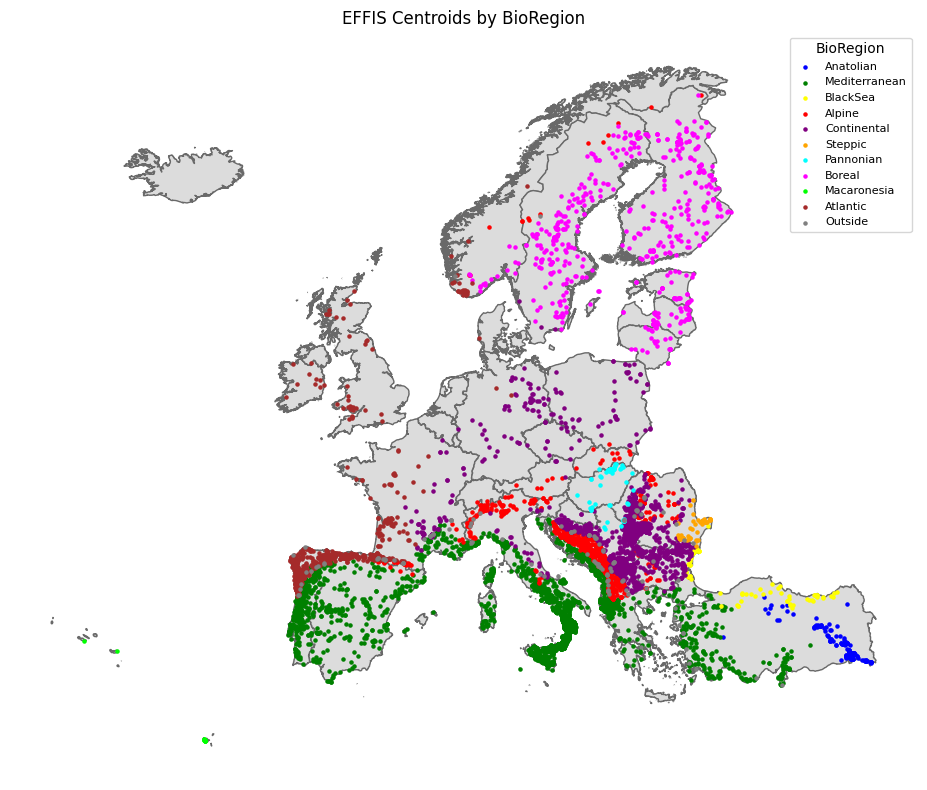

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assumes 'Europe_outline' and 'effis_with_bioregion' exist
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Base map
Europe_filtered.plot(ax=ax, color='gainsboro', edgecolor='dimgray')

# Centroids colored by BioRegion
centroids = effis_with_bioregion.geometry.centroid
unique_bioregions = effis_with_bioregion['BioRegion'].dropna().unique()  # Drop NaN from unique list

# Define colors for all 10 BioRegions + NaN
colors_list = [
    'blue',      # Steppic
    'green',     # Mediterranean
    'yellow',    # Alpine
    'red',       # Continental
    'purple',    # BlackSea
    'orange',    # Pannonian
    'cyan',      # Boreal
    'magenta',   # Macaronesia
    'lime',      # Atlantic
    'brown'      # Extra color if needed
]
color_map = dict(zip(unique_bioregions, colors_list[:len(unique_bioregions)]))
color_map[np.nan] = 'gray'  # Default color for NaN

# Extract x, y coordinates from centroids
x = centroids.x
y = centroids.y
colors = effis_with_bioregion['BioRegion'].map(lambda x: color_map.get(x, color_map[np.nan]))

# Plot each BioRegion category separately for legend
handles = []
for bioregion, color in color_map.items():
    # Use pd.isna() for NaN check, == for specific values
    mask = effis_with_bioregion['BioRegion'].isna() if pd.isna(bioregion) else (effis_with_bioregion['BioRegion'] == bioregion)
    scatter = ax.scatter(
        x[mask], y[mask],
        c=color,
        s=5,
        label='Outside' if pd.isna(bioregion) else bioregion
    )
    handles.append(scatter)

# Add legend
ax.legend(handles=handles, title='BioRegion', loc='best', fontsize=8, title_fontsize=10)

ax.set_title('EFFIS Centroids by BioRegion')
ax.set_axis_off()
plt.tight_layout()
plt.show()

Creating box plot for 12057 records.


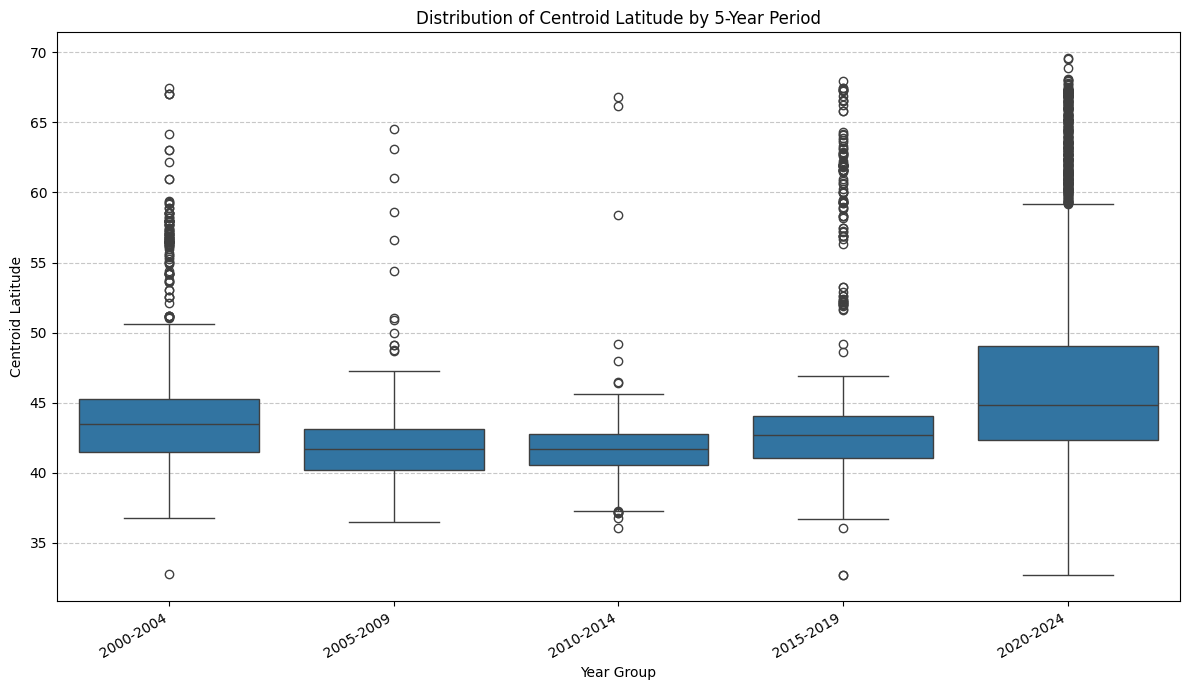

In [51]:
import geopandas as gpd # Keep in case effis_clipped is still a GeoDataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'effis_clipped' DataFrame exists
# Requires 'Date', 'geometry' (or 'centroid_lat') columns

# Use a shorter variable name if preferred
df = effis_clipped

# --- 1. Ensure necessary columns exist ---
# Check for 'Date'
if 'Date' not in df.columns:
    print("Error: DataFrame is missing the 'Date' column.")
    exit()

# Check for/Create 'centroid_lat'
if 'centroid_lat' not in df.columns:
    if 'geometry' in df.columns:
        try:
            print("Calculating 'centroid_lat' from geometry...")
            df['centroid_lat'] = df.geometry.centroid.y
        except Exception as e:
            print(f"Error calculating centroid latitude: {e}")
            exit()
    else:
        print("Error: Cannot find or calculate 'centroid_lat'. Missing 'geometry' column too.")
        exit()
elif not pd.api.types.is_numeric_dtype(df['centroid_lat']):
     print("Warning: 'centroid_lat' column is not numeric. Attempting conversion...")
     df['centroid_lat'] = pd.to_numeric(df['centroid_lat'], errors='coerce')


# --- 2. Extract Year and Create 5-Year Groups ---
# Extract year (first 4 characters of Date) and convert to numeric
# Using errors='coerce' will turn non-convertible values into NaN
df['year'] = pd.to_numeric(df['Date'].astype(str).str[:4], errors='coerce')

# Define bins and labels for 5-year periods (based on 2000-2004, 2005-2009 examples)
bins = [1999, 2004, 2009, 2014, 2019, 2024] # Year interval edges (exclusive left, inclusive right)
labels = ['2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2024']

# Create the 'year_group' column using pandas.cut
df['year_group'] = pd.cut(df['year'], bins=bins, labels=labels, right=True)

# --- 3. Prepare Data for Plotting ---
# Filter out rows where year extraction failed, group assignment failed,
# year is outside the desired range (implicitly handled by pd.cut),
# or latitude is invalid.
plot_data = df.dropna(subset=['year_group', 'centroid_lat']).copy()

if plot_data.empty:
    print("No valid data remaining after filtering for years 2000-2024 and valid latitude.")
else:
    print(f"Creating box plot for {len(plot_data)} records.")

    # --- 4. Create Box Plot using Seaborn ---
    plt.figure(figsize=(12, 7)) # Set figure size

    # Create the boxplot, ensuring chronological order on x-axis
    sns.boxplot(data=plot_data, x='year_group', y='centroid_lat', order=labels)

    # --- 5. Customize Plot ---
    plt.title('Distribution of Centroid Latitude by 5-Year Period')
    plt.xlabel('Year Group')
    plt.ylabel('Centroid Latitude')
    plt.xticks(rotation=30, ha='right') # Rotate labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines
    plt.tight_layout() # Adjust layout
    plt.show() # Display the plot

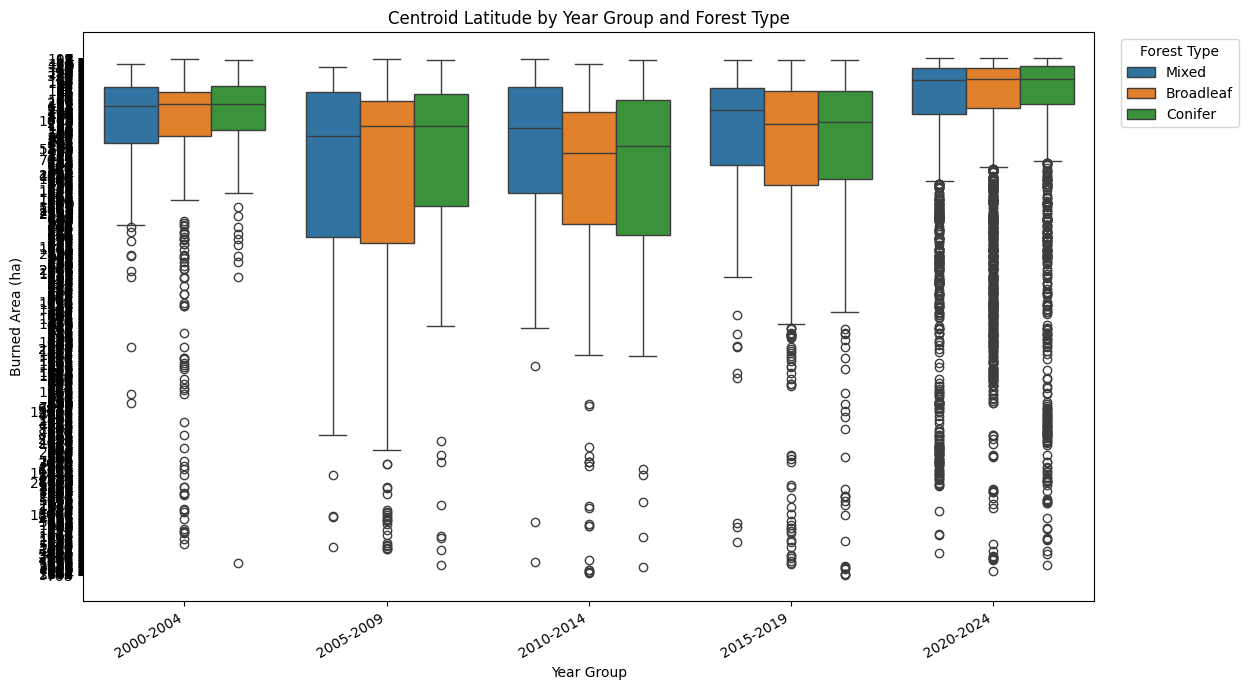

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd # Keep if df is a GeoDataFrame

# Assume 'df' DataFrame exists
# Assume 'Date', 'centroid_lat', 'ForestType' columns exist

# --- Create Year Groups ---
# Extract year (first 4 chars of Date)
# *** FIX: Use errors='coerce' to turn non-numeric years into NaN ***
df['year'] = pd.to_numeric(df['Date'].astype(str).str[:4], errors='coerce')

# Define 5-year bins and labels (2000-2024)
bins = [1999, 2004, 2009, 2014, 2019, 2024]
labels = ['2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2024']
# This line should now work correctly
df['year_group'] = pd.cut(df['year'], bins=bins, labels=labels, right=True)

# --- Create Plot ---
plt.figure(figsize=(14, 7)) # Adjust size if needed

# NaN values in 'year_group' or 'centroid_lat' will be automatically ignored by seaborn
sns.boxplot(
    data=df,
    x='year_group',
    y='AREA_HA',
    hue='ForestType',
    order=labels
)

# --- Customize ---
plt.title('Centroid Latitude by Year Group and Forest Type')
plt.xlabel('Year Group')
plt.ylabel('Burned Area (ha)')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Forest Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()